# Optymalizacja systemów i sieci informatycznych nowej generacji

Celem zadania jest przeprowadzenie porównania implementacji problemu rozmieszczenia sieci programowalnej zaimplementowanego na podstawie załączonego [artykułu](https://www.researchgate.net/publication/264625467_On_the_Capacitated_Controller_Placement_Problem_in_Software_Defined_Networks) oraz z wykorzystaniem biblioteki geeko. Zgodnie z ustalonymi wytycznymi, analiza obejmować będzie zmiany dwóch zmiennych które, dla których trzykrotnie zostaną rozpatrzone różne instancje problemu. Porównane zostaną otrzymane wyniki, skuteczność oraz czas działania algorytmów.

Rozpatrywanymi przez nas zmiennymi będą:
 - liczba switchy
 - obciązenie switchy 

Autorzy
 - Ewa Sakowicz
 - Piotr Krakowiak

## Implementacja logiki odpowiedzialnej za porównywanie rozwiązań 

Rozpocznijmy od zdefiniowania kilku wartości które pozostaną stałe na przestrzeni całej analizy.

In [1]:
number_of_controllers: int = 3
controllers_capacities_model: list = [80, 10, 5]
x_range: tuple = (0, 90)
y_range: tuple = (0, 180)

Kolejnym krokiem będzie stworzenie reużywalnej klasy reprezentującej instancje problemu która ułatwi nam przeprowadzenie porówań zaimplementowanych algorytmów. 

In [2]:
import random
import numpy as np

class ProblemInstance:
    number_of_switches: int
    switches: list
    switches_loads: list
    switch_locations: list
    distances: list
    controller_capacities_algorithm: list

    def __init__(self, number_of_switches: int, loads: list) -> None:
        if len(loads) != number_of_switches:
            raise ValueError("Number of switches does not match with number of passed loads")

        self.number_of_switches = number_of_switches
        self.switches = list(range(number_of_switches))
        self.switch_locations = self.initialize_switch_locations(number_of_switches)
        self.distances = self.initialize_distances()
        self.controller_capacities_algorithm = self.initialize_controller_capacities_algorithm(number_of_switches)
        self.switches_loads = loads


    def initialize_switch_locations(self, number_of_switches: int) -> list:
        locations = []
        for switch in range(number_of_switches):
            x = random.uniform(x_range[0], x_range[1])
            y = random.uniform(y_range[0], y_range[1])
            locations.append((x, y))
        return locations

    def initialize_distances(self) -> list:
        distances = np.zeros((len(self.switches), len(self.switches)))
        for i, switch_i in enumerate(self.switches):
            for j, switch_j in enumerate(self.switches):
                if i != j:
                    xi, yi = self.switch_locations[switch_i]
                    xj, yj = self.switch_locations[switch_j]
                    distance = np.sqrt((xi - xj) ** 2 + (yi - yj) ** 2)
                    distances[i][j] = distances[j][i] = distance
        return distances
    
    def initialize_controller_capacities_algorithm(self, number_of_switches: int) -> list:
        capacities = []
        
        if number_of_switches <= 2:
            for index in range(number_of_switches):
                capacities.append(controllers_capacities_model[index])
        else:
            for index in range(2):
                capacities.append(controllers_capacities_model[index])
                
            for index in range(number_of_switches - 2):
                capacities.append(controllers_capacities_model[-1])
            
        return capacities
            
    
    def print_instance(self) -> None:
        print(f'number of switches: {self.number_of_switches}, loads: {self.switches_loads}')

Następnie zdefinujmy zmienne które zostaną wykorzystane podczas analizy.

In [3]:
number_of_instances = 3
instances_switches = (2, 4, 6)
instance_loads_1 = ([1, 1], [1, 2], [2, 2])
instance_loads_2 = ([1, 1, 1, 1], [1, 2, 4, 6], [6, 6, 6, 6])
instance_loads_3 = ([1, 1, 1, 1, 1, 1], [1, 2, 4, 6, 8, 10], [10, 10, 10, 10, 10, 10])
instances_loads = [instance_loads_1, instance_loads_2, instance_loads_3]

Na podstawie zdefiniowanych zmiennych, możemy stworzyć kolejne instancje problemów

In [4]:
if len(instances_switches) != len(instances_loads):
    raise ValueError("Number of instance switches does not match instances loads")

instances = []
for instance_number in range(number_of_instances):
        switch_instance = []
        for loads in instances_loads[instance_number]:
            switch_instance.append(ProblemInstance(instances_switches[instance_number], loads))
        instances.append(switch_instance)

In [5]:
for instance in instances:
    for switch_instance in instance:
        switch_instance.print_instance()

number of switches: 2, loads: [1, 1]
number of switches: 2, loads: [1, 2]
number of switches: 2, loads: [2, 2]
number of switches: 4, loads: [1, 1, 1, 1]
number of switches: 4, loads: [1, 2, 4, 6]
number of switches: 4, loads: [6, 6, 6, 6]
number of switches: 6, loads: [1, 1, 1, 1, 1, 1]
number of switches: 6, loads: [1, 2, 4, 6, 8, 10]
number of switches: 6, loads: [10, 10, 10, 10, 10, 10]


Posiadając rozpatrywane instancje możemy stworzyć funkcje które pozowolą nam na analize zaimplementowanych algorytmow.

In [6]:
from time import time
from implementations import geeko_implementation

def analyse_geeko():
    results = []
    for instance in instances:
        instance_results = []
        for switch_instance in instance:
            start_time = time()
            geeko_implementation(
                switch_instance.number_of_switches,
                number_of_controllers,
                switch_instance.controller_capacities_algorithm,
                switch_instance.switches_loads,
                switch_instance.distances,
                number_of_controllers)
            end_time = time()
            time_taken = end_time - start_time
            instance_results.append((time_taken))
        results.append(instance_results)
    return results
    
geeko_results = analyse_geeko()

In [7]:
from implementations import article_implementation

def analyse_article():
    results = []
    for instance in instances:
        instance_results = []
        for switch_instance in instance:
            start_time = time()
            article_implementation(
                switch_instance.number_of_switches,
                switch_instance.controller_capacities_algorithm,
                switch_instance.switches_loads,
                switch_instance.distances,
                number_of_controllers)
            end_time = time()
            time_taken = end_time - start_time
            instance_results.append((time_taken))
        results.append(instance_results)
    return results

article_results = analyse_article()

## Porównanie czasu wykonywania

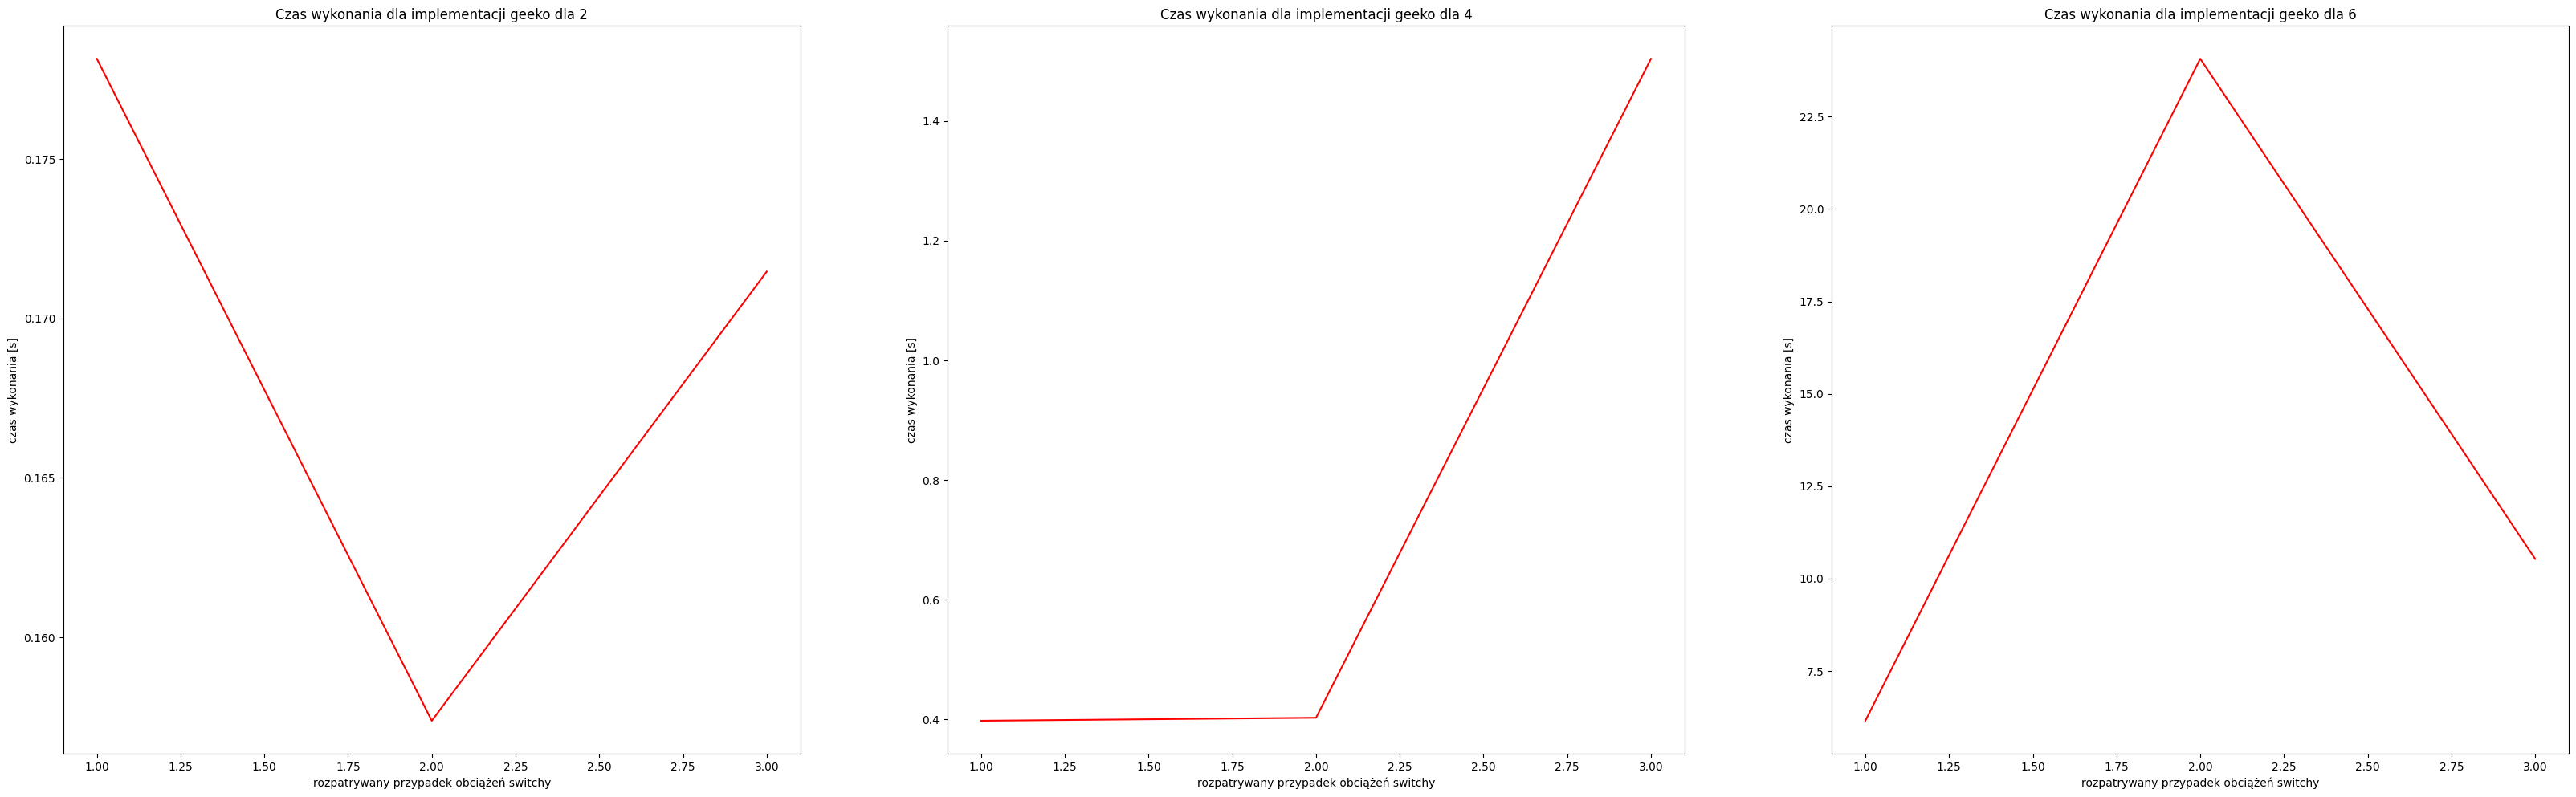

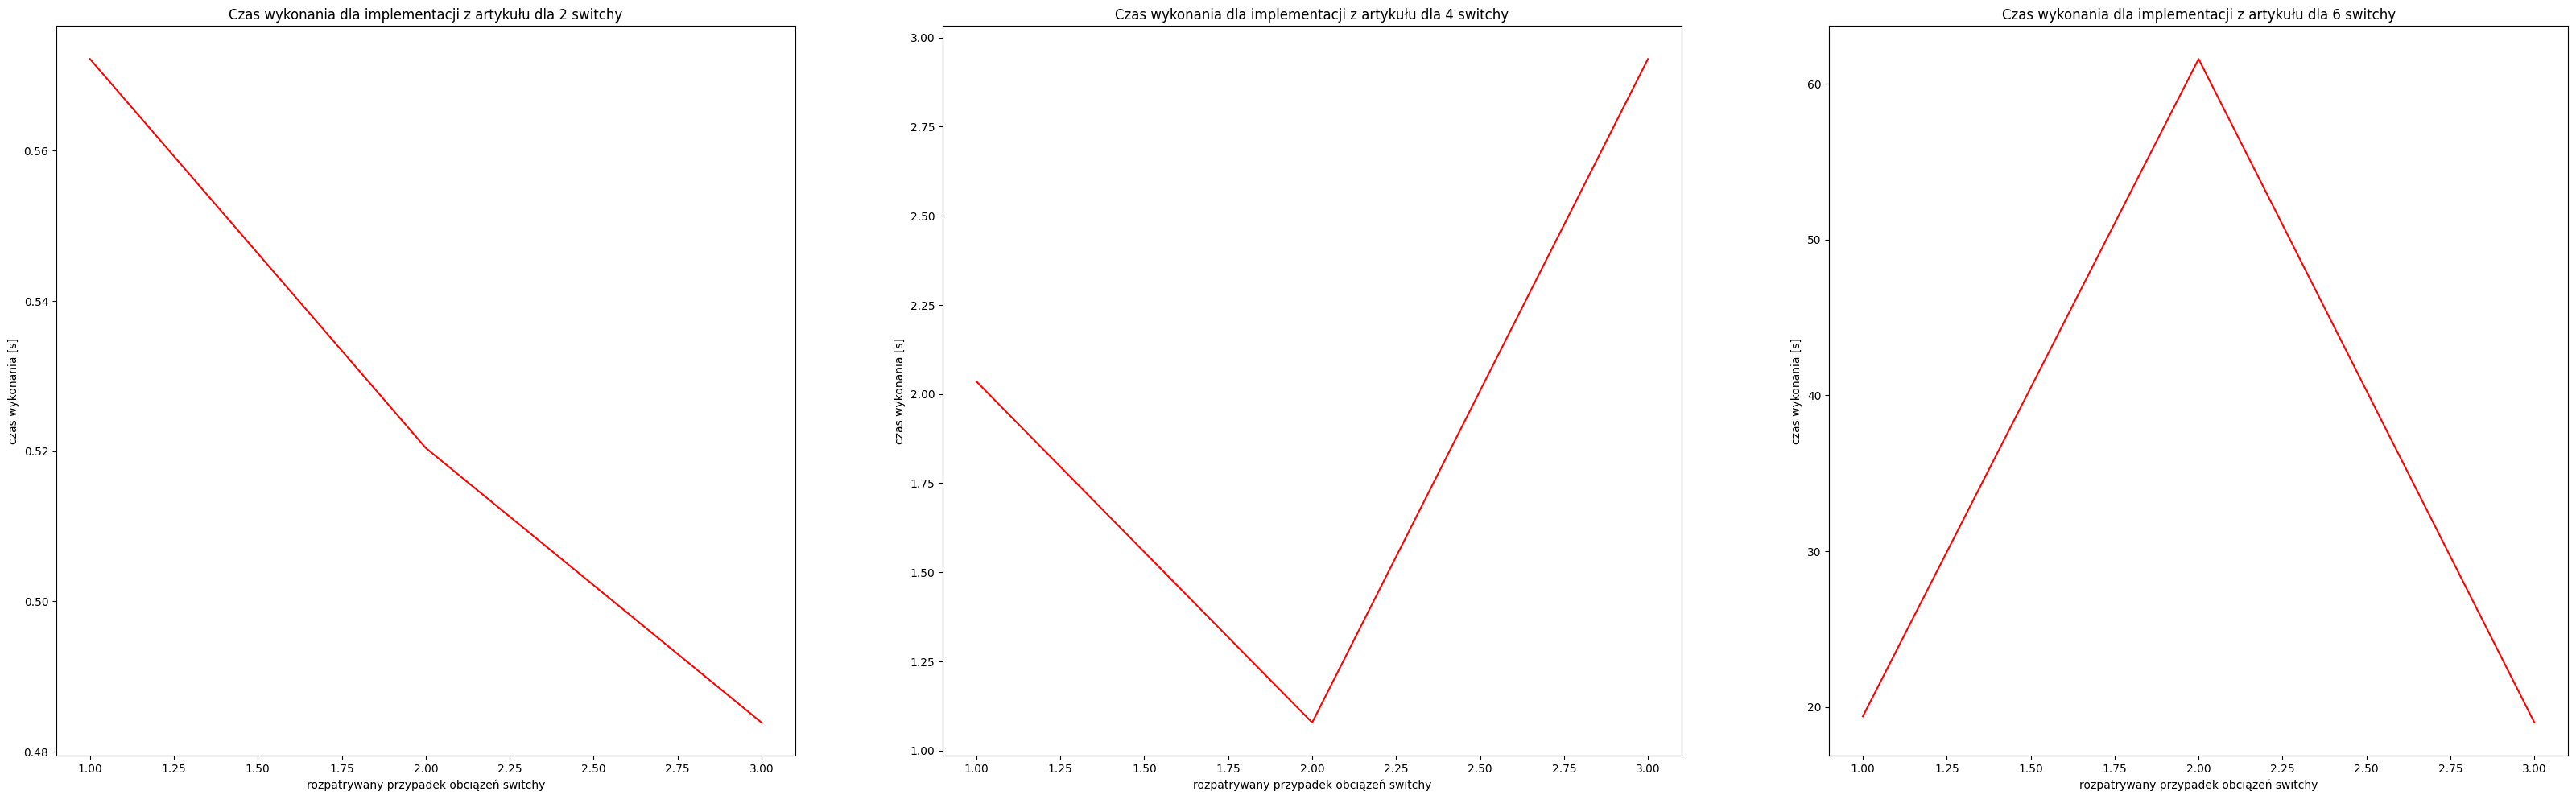

In [44]:
import matplotlib.pyplot as plt

if len(geeko_results) != len(article_results):
    raise ValueError("Invalid number of results")

x = [1, 2, 3]

for result_number, result in enumerate(geeko_results):
    y = result
    plt.subplot(1, 3, result_number + 1)
    plt.title(f"Czas wykonania dla implementacji geeko dla {instances_switches[result_number]}")
    plt.xlabel("rozpatrywany przypadek obciążeń switchy")
    plt.ylabel("czas wykonania [s]")
    plt.plot(x, y, color="red")
    
plt.subplots_adjust(top=2, right=5)
plt.show()

for result_number, result in enumerate(article_results):
    y = result
    plt.subplot(1, 3, result_number + 1)
    plt.title(f"Czas wykonania dla implementacji z artykułu dla {instances_switches[result_number]} switchy")
    plt.xlabel("rozpatrywany przypadek obciążeń switchy")
    plt.ylabel("czas wykonania [s]")
    plt.plot(x, y, color="red")
    
plt.subplots_adjust(top=2, right=5)
plt.show()  

## Porównanie ...

## Porównanie ...

## Wnioski